In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_table("wildfires.txt", delim_whitespace=True)
data['fire'] = data['fire'].map({"yes":1, "no":0})

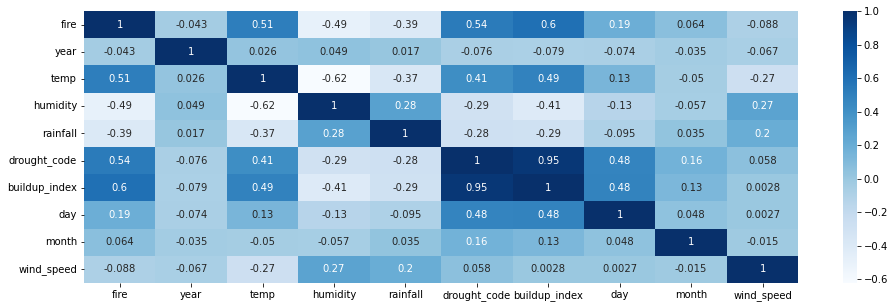

In [3]:
corr = data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, cmap="Blues",annot = True)
plt.savefig("Heatmap")

# Perceptron From Scratch - @Anushka Anil Padwal

In [4]:
class Perceptron:
    
    #activation function for the perceptron
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    #constructor call
    def __init__(self):
        self.learning_rate = None
        self.epochs = None
        self.weights = None
        self.bias = None

    #fit function to adjust weights and bias for a certain number of epochs
    def fit(self, X_train, Y_train, epochs = 100, learning_rate= 0.00001):
        data_size, vector_size = X_train.shape
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight = np.random.rand(vector_size)
        self.bias = 0
        for i in range(self.epochs):
            for x, y in zip(X_train, Y_train):
                Y_pred = self.sigmoid(np.dot(x, self.weight) + self.bias)
                self.weight += self.learning_rate * (y - Y_pred) * x
                self.bias += self.learning_rate * (y - Y_pred)

    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weight) + self.bias)

In [5]:
#splitiing datta 1/3 for test 2/3 for training and crossvalidation
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [6]:
#scaling data such that mean is zero and standard deviation as one
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

In [7]:
#splitting x and y data
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [8]:
#pandas to numpy for mathematical operations
X_train = X_train.to_numpy().reshape(X_train.shape[0], 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],) 
X_test = X_test.to_numpy().reshape(X_test.shape[0], 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#function outputs 5 models trained using crossvalidation
def crossvalidation(X_train, Y_train, splits):
    cv = KFold(n_splits=splits)
    models = []
    for train, test in cv.split(X_train):
        roundoff = lambda x: np.round(x)
        x_train = X_train[train]
        y_train = Y_train[train]
        x_val = X_train[test]
        y_val = Y_train[test]

        p = Perceptron()
        p.fit(x_train, y_train, 100, 0.00001)
        y_pred = roundoff(p.predict(x_val))
        print("model accuracy : ",accuracy_score(y_val, y_pred))
        models.append(p)
    return models

In [10]:
models = crossvalidation(X_train, Y_train, 5)

model accuracy :  0.8928571428571429
model accuracy :  0.7777777777777778
model accuracy :  0.7037037037037037
model accuracy :  0.8518518518518519
model accuracy :  0.6666666666666666


In [11]:
#this fucntion outputs probabilites and discrete values of the preditions made on Y_test as a list
def predictions_cross_val(models, X_test):
    probablities = np.empty(0, )
    discrete_vals = np.empty(0, )
    for test in X_test:
        roundoff = lambda x: np.round(x)
        pred = np.average([models[0].predict(test), 
                   models[1].predict(test),
                   models[2].predict(test),
                   models[3].predict(test),
                   models[4].predict(test)])
        probablities = np.append(probablities, pred)
        discrete_vals = np.append(discrete_vals, roundoff(pred))
        
    return probablities, discrete_vals

In [12]:
Y_pred_probabilities, Y_pred = predictions_cross_val(models, X_test)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(Y_pred,  Y_test)

0.8235294117647058

In [14]:
confusion_matrix(Y_test, Y_pred)

array([[26,  5],
       [ 7, 30]], dtype=int64)

In [15]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81        31
           1       0.86      0.81      0.83        37

    accuracy                           0.82        68
   macro avg       0.82      0.82      0.82        68
weighted avg       0.83      0.82      0.82        68



In [16]:
#saving roc data for plotting later
from sklearn.metrics import roc_curve, auc

fpr_perceptron, tpr_preceptron, threshold = roc_curve(Y_test, Y_pred_probabilities)
auc_perceptron = auc(fpr_perceptron, tpr_preceptron)

# MLP Classifier from scratch @Smitesh Nitin Patil

In [17]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        pass

    # computes partial derivatives for adjusting weights
    def backward_propagation(self, output_error, learning_rate):
        pass

In [18]:
class WeightedLayer(Layer):
    # input no of layers output no of outputs
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) -0.5
        self.bias = np.random.rand(1, output_size) -0.5

    # returns wx+b
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    # computes partial derivatives and updates weights {weight = weight - alpha*partialderivative}
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [19]:
class Sigmoid(Layer):
    
    #activation function
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    #activation derivative
    def sigmoid_derivative(self, x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def __init__(self):
        pass
    
    # applying sigmoid to the FClayer output
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.sigmoid(self.input)
        return self.output

    
    # applying sigmoid derivative to the Activation layer
    def backward_propagation(self, output_error, learning_rate):
        return self.sigmoid_derivative(self.input) * output_error

In [20]:
class Network:
    
    def __init__(self):
        self.layers = []
        
    #loss function    
    def mean_squared_error_derivative(self, Y_true, Y_pred):
        return 2*(Y_pred - Y_true)/ Y_true.size

    # add layers to network
    def add(self, layer):
        self.layers.append(layer)

    #predict output for a list of inputdata
    def predict(self, input_data):
        result = np.empty(0, )

        #calculate results for all the data
        for i in range(len(input_data)):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result = np.append(result, output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):

        #training for a number of epochs
        for i in range(epochs):
            for j in range(len(x_train)):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # backward propagation
                error = self.mean_squared_error_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)


In [21]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [22]:
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [23]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], 1, 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 1, 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validation(X_train, Y_train, splits):
    roundoff = lambda x: np.round(x)
    cv = KFold(n_splits=splits)
    models = []
    for train, test in cv.split(X_train):
        x_train = X_train[train]
        y_train = Y_train[train]
        x_val = X_train[test]
        y_val = Y_train[test]

        net = Network()
        net.add(WeightedLayer(3, 25))                
        net.add(Sigmoid())
        net.add(WeightedLayer(25, 1))                  
        net.add(Sigmoid())
        net.fit(x_train, y_train, epochs = 35, learning_rate = 0.001)
        y_pred = roundoff(net.predict(x_val))
        print(accuracy_score(y_val, y_pred))
        models.append(net)
    return models

In [25]:
models = cross_validation(X_train, Y_train, 5)

0.9285714285714286
0.8148148148148148
0.8518518518518519
0.8888888888888888
0.7037037037037037


In [26]:
Y_pred_probabilities, Y_pred = predictions_cross_val(models, X_test)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(Y_test, Y_pred)

0.8676470588235294

In [28]:
confusion_matrix(Y_test, Y_pred)

array([[23,  8],
       [ 1, 36]], dtype=int64)

In [29]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84        31
           1       0.82      0.97      0.89        37

    accuracy                           0.87        68
   macro avg       0.89      0.86      0.86        68
weighted avg       0.88      0.87      0.86        68



In [30]:
from sklearn.metrics import roc_curve, auc

fpr_mlp, tpr_mlp, threshold = roc_curve(Y_test, Y_pred_probabilities)
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Perceptron Sklearn for Reference @ Anushka Anil Padwal

In [31]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [32]:
#scaling data such that mean is zero and standard deviation as one
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

In [33]:
#splitting data in X and y
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [34]:
# converting to numpy for mathematical operations
X_train = X_train.to_numpy().reshape(X_train.shape[0], 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [35]:
#function outputs 5 models trained using crossvalidation
from sklearn.model_selection import KFold
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

def cross_validation(X_train, Y_train, splits):
    roundoff = lambda x: np.round(x)
    cv = KFold(n_splits=splits)
    models = []
    for train, test in cv.split(X_train):
        x_train = X_train[train]
        y_train = Y_train[train]
        x_val = X_train[test]
        y_val = Y_train[test]

        p = Perceptron(alpha = 0.0001)
        p.fit(X_train, Y_train)
        y_pred = roundoff(p.predict(x_val))
        print(accuracy_score(y_val, y_pred))
        models.append(p)
    return models

In [36]:
models = cross_validation(X_train, Y_train, 5)

0.9285714285714286
0.8518518518518519
0.8148148148148148
0.8888888888888888
0.6666666666666666


In [37]:
#this function outputs probabilites and discrete values of the preditions made on Y_test as a list

def predictions_cross_val(models, X_test):
    probablities = np.empty(0, )
    discrete_vals = np.empty(0, )
    for test in X_test:
        roundoff = lambda x: np.round(x)
        pred = np.average([models[0].predict(test.reshape(1, -1)), 
                   models[1].predict(test.reshape(1, -1)),
                   models[2].predict(test.reshape(1, -1)),
                   models[3].predict(test.reshape(1, -1)),
                   models[4].predict(test.reshape(1, -1))])
        probablities = np.append(probablities, pred)
        discrete_vals = np.append(discrete_vals, roundoff(pred))
        
    return probablities, discrete_vals

In [38]:
Y_pred_probabilities, Y_pred = predictions_cross_val(models, X_test)

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# performance metrics
accuracy_score(Y_test, Y_pred)

0.8823529411764706

In [40]:
confusion_matrix(Y_test, Y_pred)

array([[24,  7],
       [ 1, 36]], dtype=int64)

In [41]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       0.84      0.97      0.90        37

    accuracy                           0.88        68
   macro avg       0.90      0.87      0.88        68
weighted avg       0.89      0.88      0.88        68



# MLP Sklearn for reference @Smitesh Nitin Patil

In [42]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [43]:
#scaling data such that mean is zero and standard deviation as one
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

In [44]:
#splitting data in X and y
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [45]:
# converting to numpy for mathematical operations
X_train = X_train.to_numpy().reshape(X_train.shape[0], 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [46]:
#function outputs 5 models trained using crossvalidation
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def cross_validation(X_train, Y_train, splits):
    roundoff = lambda x: np.round(x)
    cv = KFold(n_splits=splits)
    models = []
    for train, test in cv.split(X_train):
        x_train = X_train[train]
        y_train = Y_train[train]
        x_val = X_train[test]
        y_val = Y_train[test]

        mlp= MLPClassifier(solver = 'sgd', hidden_layer_sizes = (25, ) ,alpha= 0.00001)
        mlp.fit(X_train, Y_train)
        y_pred = roundoff(mlp.predict(x_val))
        print(accuracy_score(y_val, y_pred))
        models.append(mlp)
    return models

In [47]:
models = cross_validation(X_train, Y_train, 5)

0.9285714285714286
0.8148148148148148
0.7037037037037037
0.8518518518518519
0.6666666666666666


In [48]:
Y_pred_probabilities, Y_pred = predictions_cross_val(models, X_test)

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(Y_test, Y_pred)

0.8676470588235294

In [50]:
confusion_matrix(Y_test, Y_pred)

array([[27,  4],
       [ 5, 32]], dtype=int64)

In [51]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86        31
           1       0.89      0.86      0.88        37

    accuracy                           0.87        68
   macro avg       0.87      0.87      0.87        68
weighted avg       0.87      0.87      0.87        68



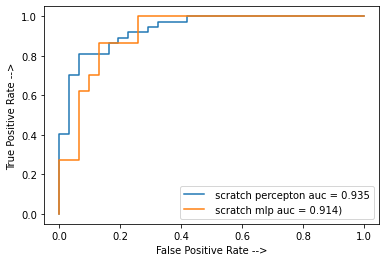

In [52]:
plt.plot(fpr_perceptron, tpr_preceptron, linestyle='-', label=' scratch percepton auc = %0.3f' % auc_perceptron)
plt.plot(fpr_mlp, tpr_mlp, linestyle='-', label=' scratch mlp auc = %0.3f)' % auc_mlp)


plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
    
plt.legend()
plt.savefig("Roc curve")
plt.show()